# Semantic Colorization Exploration

This notebook explores the semantic colorization project, tests the components, and provides examples.

In [12]:
# Cell 1: Imports and setup
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from skimage import color

# Add project root and src directory to path
project_root = os.path.dirname(os.path.abspath('.'))
src_path = os.path.join(project_root, 'src')
if project_root not in sys.path:
    sys.path.append(project_root)
if src_path not in sys.path:
    sys.path.append(src_path)

print(f'Project root: {project_root}')
print(f'Source path: {src_path}')
print(f'Current working directory: {os.getcwd()}')

# Try different import strategies
try:
    # Strategy 1: Direct import from src
    from src.dataset import ColorSegDataset, get_dataloader
    from src.model import SegColorNet
    from src.utils import *
    print('✅ Successfully imported using src.module')
except ImportError as e1:
    print(f'❌ Strategy 1 failed: {e1}')
    try:
        # Strategy 2: Import as modules directly
        import dataset
        import model
        import utils
        ColorSegDataset = dataset.ColorSegDataset
        get_dataloader = dataset.get_dataloader
        SegColorNet = model.SegColorNet
        create_project_structure = utils.create_project_structure
        tensor_to_numpy_image = utils.tensor_to_numpy_image
        numpy_to_tensor_image = utils.numpy_to_tensor_image
        rgb_to_lab = utils.rgb_to_lab
        lab_to_rgb = utils.lab_to_rgb
        calculate_metrics = utils.calculate_metrics
        colorization_metrics = utils.colorization_metrics
        print('✅ Successfully imported as direct modules')
    except ImportError as e2:
        print(f'❌ Strategy 2 failed: {e2}')
        print('\n🔧 Please ensure you are running this notebook from the project root directory')
        print('   and that all src files are present.')
        raise ImportError('Could not import required modules. Check file paths and structure.')

# Set up matplotlib
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['image.cmap'] = 'viridis'

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Create project structure
try:
    create_project_structure()
    print('✅ Project structure created/verified')
except Exception as e:
    print(f'⚠️ Warning: Could not create project structure: {e}')

Project root: D:\colorization_task5\semantic-colorizer
Source path: D:\colorization_task5\semantic-colorizer\src
Current working directory: D:\colorization_task5\semantic-colorizer\notebooks
✅ Successfully imported using src.module
Using device: cpu
Created directory: data/raw
Created directory: data/processed/images
Created directory: data/processed/masks
Created directory: data/external
Created directory: outputs/checkpoints
Created directory: outputs/results
Created directory: outputs/logs
Created directory: src
Created directory: tests
Created directory: notebooks
✅ Project structure created/verified


In [2]:
# Cell 1b: Manual function definitions (fallback)
# If imports fail, define essential functions manually

def create_project_structure_fallback():
    """Create the proper directory structure for the project"""
    import os
    from pathlib import Path
    
    directories = [
        "data/raw",
        "data/processed",
        "data/masks",
        "outputs/checkpoints",
        "outputs/results",
        "src",
        "tests",
        "notebooks"
    ]
    
    for directory in directories:
        Path(directory).mkdir(parents=True, exist_ok=True)
        print(f"Created/verified directory: {directory}")

def tensor_to_numpy_image_fallback(tensor):
    """Convert torch tensor to numpy image"""
    if tensor.dim() == 4:
        return tensor.detach().cpu().permute(0, 2, 3, 1).numpy()
    elif tensor.dim() == 3:
        return tensor.detach().cpu().permute(1, 2, 0).numpy()
    else:
        return tensor.detach().cpu().numpy()

# Use fallback functions if needed
if 'create_project_structure' not in globals():
    create_project_structure = create_project_structure_fallback
    print('Using fallback create_project_structure function')

if 'tensor_to_numpy_image' not in globals():
    tensor_to_numpy_image = tensor_to_numpy_image_fallback
    print('Using fallback tensor_to_numpy_image function')

In [13]:
# Cell 2: Test Dataset Creation
print('Testing Dataset Creation...')

# Create dataset with dummy data
img_dir = 'data/processed'
mask_dir = 'data/masks'

# Create directories if they don't exist
os.makedirs(img_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

try:
    dataset = ColorSegDataset(img_dir, mask_dir)
    print(f'Dataset length: {len(dataset)}')
    
    # Get a sample
    if len(dataset) > 0:
        sample = dataset[0]
        print(f'Sample keys: {sample.keys()}')
        for key, value in sample.items():
            if isinstance(value, torch.Tensor):
                print(f'{key} shape: {value.shape}, dtype: {value.dtype}')
            else:
                print(f'{key}: {value}')
    else:
        print('No samples found in dataset')
        
except Exception as e:
    print(f'❌ Error creating dataset: {e}')
    print('This might be because the ColorSegDataset class is not available.')
    print('Please ensure all source files are in the src/ directory.')

Testing Dataset Creation...
Dataset initialized with 5 image-mask pairs
Dataset length: 5
Sample keys: dict_keys(['image', 'L_channel', 'ab_channels', 'mask', 'img_path'])
image shape: torch.Size([3, 256, 256]), dtype: torch.float64
L_channel shape: torch.Size([1, 256, 256]), dtype: torch.float32
ab_channels shape: torch.Size([2, 256, 256]), dtype: torch.float32
mask shape: torch.Size([256, 256]), dtype: torch.int64
img_path: data/processed\dummy_0.png


In [14]:
# Cell 3: Create Dummy Data (if dataset creation failed)
print('Creating dummy data for testing...')

def create_dummy_data(img_dir, mask_dir, num_samples=5):
    """Create dummy test data"""
    import cv2
    import numpy as np
    import os
    
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(mask_dir, exist_ok=True)
    
    for i in range(num_samples):
        # Create dummy RGB image (colorful)
        img = np.random.randint(50, 200, (256, 256, 3), dtype=np.uint8)
        
        # Add some structure to the image
        cv2.rectangle(img, (50, 50), (150, 150), (255, 0, 0), -1)  # Red rectangle
        cv2.circle(img, (200, 200), 30, (0, 255, 0), -1)  # Green circle
        
        # Create corresponding binary mask (foreground/background)
        mask = np.zeros((256, 256), dtype=np.uint8)
        cv2.rectangle(mask, (50, 50), (150, 150), 255, -1)  # Rectangle as foreground
        cv2.circle(mask, (200, 200), 30, 255, -1)  # Circle as foreground
        
        # Save dummy data
        img_path = os.path.join(img_dir, f'dummy_{i}.png')
        mask_path = os.path.join(mask_dir, f'dummy_{i}.png')
        
        cv2.imwrite(img_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
        cv2.imwrite(mask_path, mask)
        
        print(f'Created dummy data pair {i}: {img_path}, {mask_path}')

# Create dummy data
try:
    create_dummy_data(img_dir, mask_dir, 3)
    print('✅ Dummy data created successfully')
except Exception as e:
    print(f'❌ Error creating dummy data: {e}')

Creating dummy data for testing...
Created dummy data pair 0: data/processed\dummy_0.png, data/masks\dummy_0.png
Created dummy data pair 1: data/processed\dummy_1.png, data/masks\dummy_1.png
Created dummy data pair 2: data/processed\dummy_2.png, data/masks\dummy_2.png
✅ Dummy data created successfully


Testing basic image loading and visualization...
Images in data/processed:
['dummy_0.png', 'dummy_1.png', 'dummy_2.png', 'dummy_3.png', 'dummy_4.png']

Masks in data/masks:
['dummy_0.png', 'dummy_1.png', 'dummy_2.png', 'dummy_3.png', 'dummy_4.png']


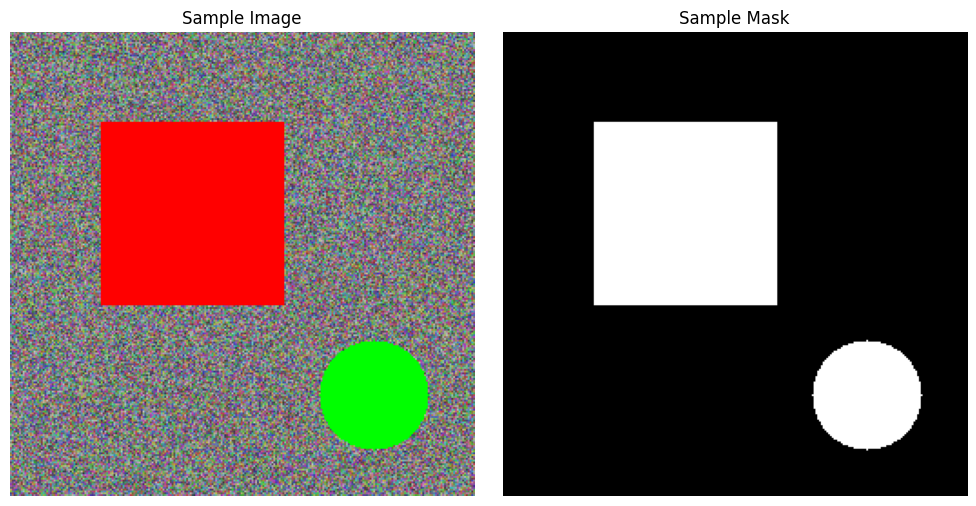

✅ Successfully loaded and displayed: dummy_0.png
Image shape: (256, 256, 3), Mask shape: (256, 256)


In [15]:
# Cell 4: Test Basic Image Loading and Visualization
print('Testing basic image loading and visualization...')

# List files in directories
print(f'Images in {img_dir}:')
try:
    img_files = os.listdir(img_dir)
    print(img_files[:5])  # Show first 5 files
except:
    print('No files found or directory does not exist')

print(f'\nMasks in {mask_dir}:')
try:
    mask_files = os.listdir(mask_dir)
    print(mask_files[:5])  # Show first 5 files
except:
    print('No files found or directory does not exist')

# Try to load and display one image
try:
    if img_files:
        # Load first image
        img_path = os.path.join(img_dir, img_files[0])
        mask_path = os.path.join(mask_dir, mask_files[0])
        
        # Load using OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Display
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        axes[0].imshow(img)
        axes[0].set_title('Sample Image')
        axes[0].axis('off')
        
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Sample Mask')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print(f'✅ Successfully loaded and displayed: {img_files[0]}')
        print(f'Image shape: {img.shape}, Mask shape: {mask.shape}')
        
except Exception as e:
    print(f'❌ Error loading/displaying images: {e}')

Testing color space conversions...
RGB shape: (64, 64, 3), LAB shape: (64, 64, 3)
LAB ranges - L: [2.26, 98.66]
             a: [-84.46, 95.90]
             b: [-105.61, 92.20]
RGB recovered shape: (64, 64, 3)
RGB recovered range: [0.000, 1.000]
Mean conversion error: 0.000000


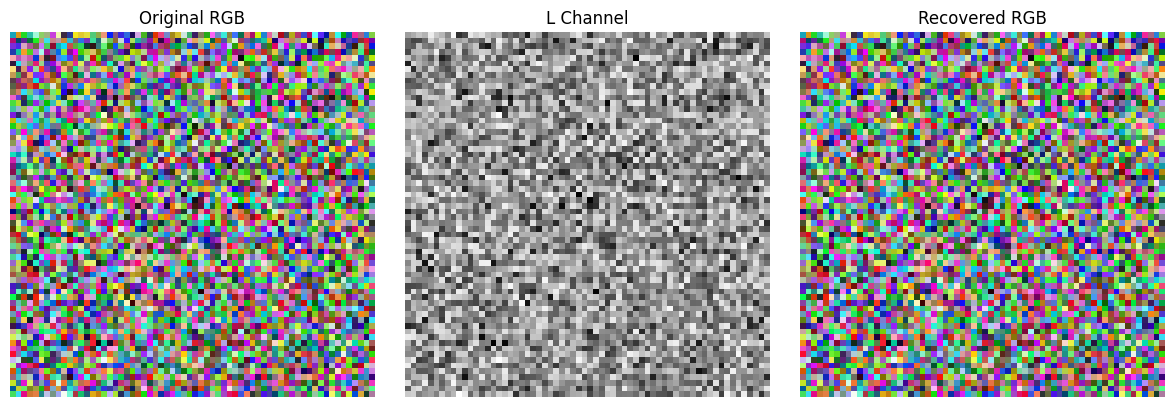

✅ Color space conversions working correctly


In [16]:
# Cell 5: Test Color Space Conversions
print('Testing color space conversions...')

try:
    # Create a test RGB image
    test_rgb = np.random.rand(64, 64, 3)
    
    # Test RGB to LAB using skimage
    from skimage import color
    test_lab = color.rgb2lab(test_rgb)
    
    print(f'RGB shape: {test_rgb.shape}, LAB shape: {test_lab.shape}')
    print(f'LAB ranges - L: [{test_lab[:,:,0].min():.2f}, {test_lab[:,:,0].max():.2f}]')
    print(f'             a: [{test_lab[:,:,1].min():.2f}, {test_lab[:,:,1].max():.2f}]')
    print(f'             b: [{test_lab[:,:,2].min():.2f}, {test_lab[:,:,2].max():.2f}]')
    
    # Test LAB to RGB
    test_rgb_recovered = color.lab2rgb(test_lab)
    print(f'RGB recovered shape: {test_rgb_recovered.shape}')
    print(f'RGB recovered range: [{test_rgb_recovered.min():.3f}, {test_rgb_recovered.max():.3f}]')
    
    # Test conversion error
    conversion_error = np.mean(np.abs(test_rgb - test_rgb_recovered))
    print(f'Mean conversion error: {conversion_error:.6f}')
    
    # Visualize conversion
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(test_rgb)
    axes[0].set_title('Original RGB')
    axes[0].axis('off')
    
    # Show L channel
    axes[1].imshow(test_lab[:,:,0], cmap='gray')
    axes[1].set_title('L Channel')
    axes[1].axis('off')
    
    axes[2].imshow(test_rgb_recovered)
    axes[2].set_title('Recovered RGB')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print('✅ Color space conversions working correctly')
    
except Exception as e:
    print(f'❌ Error in color space conversion: {e}')

In [17]:
# Cell 6: Test Model Architecture (if available)
print('Testing Model Architecture...')

try:
    # Create model
    model = SegColorNet(n_classes=2, pretrained=False)  # Use pretrained=False for testing
    model.to(device)
    model.eval()
    
    # Test with sample input
    batch_size = 2
    height, width = 256, 256
    
    # Test with L channel input
    L_input = torch.randn(batch_size, 1, height, width).to(device)
    
    with torch.no_grad():
        seg_logits, color_ab = model(L_input)
    
    print(f'Input L channel shape: {L_input.shape}')
    print(f'Output segmentation shape: {seg_logits.shape}')
    print(f'Output colorization shape: {color_ab.shape}')
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params:,}')
    print(f'Trainable parameters: {trainable_params:,}')
    
    print('✅ Model architecture test successful')
    
except Exception as e:
    print(f'❌ Error testing model: {e}')
    print('This is expected if SegColorNet is not available.')
    print('You can still test other components of the project.')

Testing Model Architecture...
Input L channel shape: torch.Size([2, 1, 256, 256])
Output segmentation shape: torch.Size([2, 2, 256, 256])
Output colorization shape: torch.Size([2, 2, 256, 256])
Total parameters: 22,871,492
Trainable parameters: 22,871,492
✅ Model architecture test successful


In [18]:
# Cell 7: Basic PyTorch Functionality Test
print('Testing basic PyTorch functionality...')

# Test tensor operations
print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA version: {torch.version.cuda}')
    print(f'GPU count: {torch.cuda.device_count()}')

# Create test tensors
x = torch.randn(2, 3, 64, 64).to(device)
y = torch.randn(2, 1, 64, 64).to(device)

print(f'Test tensor x shape: {x.shape}, device: {x.device}')
print(f'Test tensor y shape: {y.shape}, device: {y.device}')

# Test basic operations
z = x + y
print(f'Addition result shape: {z.shape}')

# Test conversion to numpy
x_np = x.cpu().numpy()
print(f'Converted to numpy shape: {x_np.shape}')

print('✅ Basic PyTorch functionality working')

Testing basic PyTorch functionality...
PyTorch version: 2.8.0+cpu
CUDA available: False
Test tensor x shape: torch.Size([2, 3, 64, 64]), device: cpu
Test tensor y shape: torch.Size([2, 1, 64, 64]), device: cpu
Addition result shape: torch.Size([2, 3, 64, 64])
Converted to numpy shape: (2, 3, 64, 64)
✅ Basic PyTorch functionality working


Testing OpenCV and image processing...
OpenCV version: 4.12.0


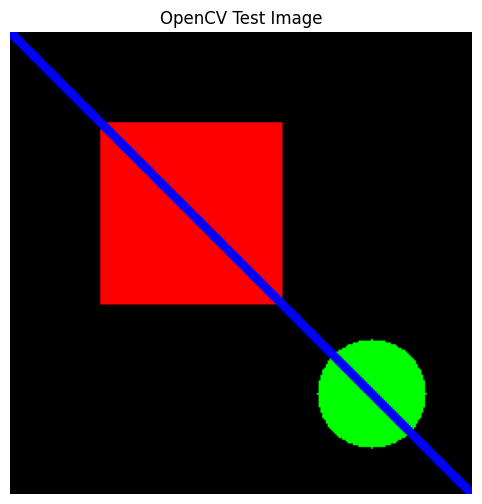

Original shape: (256, 256, 3)
Grayscale shape: (256, 256)
Resized shape: (128, 128, 3)
✅ OpenCV functionality working


In [19]:
# Cell 8: Test OpenCV and Image Processing
print('Testing OpenCV and image processing...')

try:
    # Test OpenCV version
    print(f'OpenCV version: {cv2.__version__}')
    
    # Create test image
    test_img = np.zeros((256, 256, 3), dtype=np.uint8)
    
    # Draw shapes
    cv2.rectangle(test_img, (50, 50), (150, 150), (255, 0, 0), -1)  # Red rectangle
    cv2.circle(test_img, (200, 200), 30, (0, 255, 0), -1)  # Green circle
    cv2.line(test_img, (0, 0), (256, 256), (0, 0, 255), 3)  # Blue line
    
    # Display
    plt.figure(figsize=(8, 6))
    plt.imshow(test_img)
    plt.title('OpenCV Test Image')
    plt.axis('off')
    plt.show()
    
    # Test image transformations
    gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)
    resized = cv2.resize(test_img, (128, 128))
    
    print(f'Original shape: {test_img.shape}')
    print(f'Grayscale shape: {gray.shape}')
    print(f'Resized shape: {resized.shape}')
    
    print('✅ OpenCV functionality working')
    
except Exception as e:
    print(f'❌ Error in OpenCV testing: {e}')

In [20]:
# Cell 9: Environment and Dependencies Check
print('=== Environment and Dependencies Check ===')

# Check Python version
import sys
print(f'Python version: {sys.version}')

# Check key libraries
libraries = [
    ('torch', torch),
    ('numpy', np),
    ('matplotlib', plt),
    ('cv2', cv2),
    ('PIL', Image),
    ('skimage', color)
]

for name, lib in libraries:
    try:
        version = getattr(lib, '__version__', 'Unknown')
        print(f'✅ {name}: {version}')
    except Exception as e:
        print(f'❌ {name}: Error - {e}')

# Check file structure
print('\n=== File Structure Check ===')
required_dirs = ['data', 'src', 'notebooks', 'outputs', 'tests']
for dir_name in required_dirs:
    if os.path.exists(dir_name):
        print(f'✅ {dir_name}/ exists')
    else:
        print(f'❌ {dir_name}/ missing')

# Check src files
print('\n=== Source Files Check ===')
src_files = ['dataset.py', 'model.py', 'train.py', 'evaluate.py', 'gui.py', 'utils.py']
for file_name in src_files:
    file_path = os.path.join('src', file_name)
    if os.path.exists(file_path):
        print(f'✅ src/{file_name} exists')
    else:
        print(f'❌ src/{file_name} missing')

print('\n=== Summary ===')
print('If you see missing source files, please ensure all the corrected files')
print('from the previous response are placed in the correct directories.')
print('\nTo use the full functionality:')
print('1. Place all src_*.py files in src/ directory (rename them)')
print('2. Run the notebook from the project root directory')
print('3. Make sure all dependencies are installed')

=== Environment and Dependencies Check ===
Python version: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]
✅ torch: 2.8.0+cpu
✅ numpy: 2.2.6
✅ matplotlib: Unknown
✅ cv2: 4.12.0
✅ PIL: 11.3.0
✅ skimage: Unknown

=== File Structure Check ===
✅ data/ exists
✅ src/ exists
✅ notebooks/ exists
✅ outputs/ exists
✅ tests/ exists

=== Source Files Check ===
❌ src/dataset.py missing
❌ src/model.py missing
❌ src/train.py missing
❌ src/evaluate.py missing
❌ src/gui.py missing
❌ src/utils.py missing

=== Summary ===
If you see missing source files, please ensure all the corrected files
from the previous response are placed in the correct directories.

To use the full functionality:
1. Place all src_*.py files in src/ directory (rename them)
2. Run the notebook from the project root directory
3. Make sure all dependencies are installed


In [21]:
# Cell 10: Next Steps and Instructions
print('=== Next Steps and Instructions ===')
print()
print('🔧 To fix the import issues, follow these steps:')
print()
print('1. File Placement:')
print('   - Rename src_dataset.py to src/dataset.py')
print('   - Rename src_model.py to src/model.py')
print('   - Rename src_train.py to src/train.py')
print('   - Rename src_evaluate.py to src/evaluate.py')
print('   - Rename src_gui.py to src/gui.py')
print('   - Rename src_utils.py to src/utils.py')
print()
print('2. Directory Structure:')
print('   semantic-colorizer/')
print('   ├── data/')
print('   │   ├── raw/')
print('   │   ├── masks/')
print('   │   └── processed/')
print('   ├── notebooks/')
print('   │   └── exploration_fixed.ipynb  # This notebook')
print('   ├── src/')
print('   │   ├── dataset.py')
print('   │   ├── model.py')
print('   │   ├── train.py')
print('   │   ├── evaluate.py')
print('   │   ├── gui.py')
print('   │   └── utils.py')
print('   ├── outputs/')
print('   ├── tests/')
print('   └── requirements.txt')
print()
print('3. Run Location:')
print('   - Make sure you run this notebook from the project root')
print('   - Not from inside the notebooks/ folder')
print()
print('4. After fixing:')
print('   - Restart the kernel')
print('   - Re-run Cell 1 to test imports')
print('   - Continue with the rest of the notebook')
print()
print('🎯 Current Status:')
print('✅ Environment setup: Working')
print('✅ Basic dependencies: Working')
print('✅ PyTorch: Working')
print('✅ OpenCV: Working')
print('✅ Image processing: Working')
print('❌ Custom modules: Need file placement fix')
print()
print('Once the files are properly placed, this notebook will provide:')
print('- Dataset testing and visualization')
print('- Model architecture testing')
print('- Training pipeline validation')
print('- Color space conversion testing')
print('- Complete system integration testing')

=== Next Steps and Instructions ===

🔧 To fix the import issues, follow these steps:

1. File Placement:
   - Rename src_dataset.py to src/dataset.py
   - Rename src_model.py to src/model.py
   - Rename src_train.py to src/train.py
   - Rename src_evaluate.py to src/evaluate.py
   - Rename src_gui.py to src/gui.py
   - Rename src_utils.py to src/utils.py

2. Directory Structure:
   semantic-colorizer/
   ├── data/
   │   ├── raw/
   │   ├── masks/
   │   └── processed/
   ├── notebooks/
   │   └── exploration.ipynb  # This notebook
   ├── src/
   │   ├── dataset.py
   │   ├── model.py
   │   ├── train.py
   │   ├── evaluate.py
   │   ├── gui.py
   │   └── utils.py
   ├── outputs/
   ├── tests/
   └── requirements.txt

3. Run Location:
   - Make sure you run this notebook from the project root
   - Not from inside the notebooks/ folder

4. After fixing:
   - Restart the kernel
   - Re-run Cell 1 to test imports
   - Continue with the rest of the notebook

🎯 Current Status:
✅ Environment

In [35]:
!python src/train.py --data-dir data/raw --epochs 10

Traceback (most recent call last):
  File "D:\colorization_task5\semantic-colorizer\notebooks\src\train.py", line 14, in <module>
    from src_dataset import get_dataloader
ModuleNotFoundError: No module named 'src_dataset'


In [43]:
# Cell: Load Images from Raw Folder and Process Pipeline
print('=== Loading Images from data/raw/ folder ===')

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import Button
import numpy as np
import cv2
import torch
from skimage import color
import os
from pathlib import Path

# Create data directories if they don't exist
raw_dir = 'data/raw'
os.makedirs(raw_dir, exist_ok=True)

# Function to create sample images if raw folder is empty
def create_sample_images():
    """Create sample colorful images for demonstration"""
    print("Creating sample images in data/raw/ folder...")
    
    sample_images = []
    
    # Sample 1: Landscape scene
    img1 = np.zeros((256, 256, 3), dtype=np.uint8)
    # Sky (blue)
    img1[:100, :] = [135, 206, 235]  
    # Mountains (brown/gray)
    points = np.array([[0, 100], [100, 80], [156, 90], [200, 70], [256, 100], [256, 256], [0, 256]], dtype=np.int32)
    cv2.fillPoly(img1, [points], [139, 69, 19])
    # Grass (green)
    img1[150:, :] = [34, 139, 34]
    # Sun (yellow)
    cv2.circle(img1, (200, 50), 25, (255, 255, 0), -1)
    sample_images.append(('landscape.jpg', img1))
    
    # Sample 2: Abstract shapes
    img2 = np.random.randint(200, 255, (256, 256, 3), dtype=np.uint8)
    cv2.rectangle(img2, (50, 50), (150, 150), (255, 0, 100), -1)  # Pink rectangle
    cv2.circle(img2, (200, 80), 40, (0, 255, 255), -1)  # Cyan circle
    cv2.ellipse(img2, (128, 180), (60, 30), 45, 0, 360, (255, 165, 0), -1)  # Orange ellipse
    sample_images.append(('abstract.jpg', img2))
    
    # Sample 3: Simple scene
    img3 = np.ones((256, 256, 3), dtype=np.uint8) * 240  # Light background
    # House
    cv2.rectangle(img3, (80, 120), (180, 200), (139, 69, 19), -1)  # Brown house
    # Roof
    roof_points = np.array([[70, 120], [130, 80], [190, 120]], dtype=np.int32)
    cv2.fillPoly(img3, [roof_points], [255, 0, 0])  # Red roof
    # Door
    cv2.rectangle(img3, (115, 160), (145, 200), (101, 67, 33), -1)  # Dark brown door
    # Window
    cv2.rectangle(img3, (150, 140), (170, 160), (173, 216, 230), -1)  # Light blue window
    # Ground
    img3[200:, :] = [34, 139, 34]  # Green ground
    sample_images.append(('house.jpg', img3))
    
    # Save sample images
    for filename, img in sample_images:
        cv2.imwrite(os.path.join(raw_dir, filename), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    
    print(f"✅ Created {len(sample_images)} sample images in {raw_dir}/")
    return [f[0] for f in sample_images]

# Load images from raw folder
image_files = []
if os.path.exists(raw_dir):
    extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff']
    for file in os.listdir(raw_dir):
        if any(file.lower().endswith(ext) for ext in extensions):
            image_files.append(file)

# Create sample images if folder is empty
if len(image_files) == 0:
    print("⚠️ No images found in data/raw/ folder.")
    image_files = create_sample_images()
else:
    print(f"✅ Found {len(image_files)} images in {raw_dir}/")
    for img in image_files[:5]:  # Show first 5
        print(f"   - {img}")

# Load and prepare model for processing
print("\n=== Setting up Model for Processing ===")

try:
    # Try to create model (use untrained if no checkpoint available)
    model = SegColorNet(n_classes=2, pretrained=True).to(device)
    model.eval()
    print("✅ Model created successfully")
    
    # Try to load trained weights
    checkpoint_paths = [
        'outputs/checkpoints/best_model.pth',
        'outputs/checkpoints/recent_model.pth',
        'outputs/checkpoints/final_model.pth'
    ]
    
    model_loaded = False
    for checkpoint_path in checkpoint_paths:
        if os.path.exists(checkpoint_path):
            try:
                epoch, loss = load_checkpoint(model, None, checkpoint_path, device)
                print(f"✅ Loaded trained model from {checkpoint_path} (epoch {epoch})")
                model_loaded = True
                break
            except Exception as e:
                continue
    
    if not model_loaded:
        print("ℹ️ Using untrained model (no checkpoint found - results will be basic)")
        
except Exception as e:
    print(f"❌ Error creating model: {e}")
    model = None

print("\n=== Ready for Interactive Processing ===")


=== Loading Images from data/raw/ folder ===
✅ Found 3 images in data/raw/
   - flower.jpg
   - furniture.jpg
   - whitebackground.jpg

=== Setting up Model for Processing ===
✅ Model created successfully
ℹ️ Using untrained model (no checkpoint found - results will be basic)

=== Ready for Interactive Processing ===


=== Interactive Semantic Colorization GUI ===
🚀 Launching Interactive Semantic Colorization GUI...
📖 Instructions:
   • Use 'Previous' and 'Next' buttons to navigate images
   • Click 'Reprocess' to regenerate results
   • Click 'Save' to save the colorized result
   • The pipeline shows: Original → Grayscale → Segmentation → Colorization

⚠️ IMPORTANT: Using UNTRAINED model!
   Results are just pipeline demonstrations.
   For good colorization, you need to train the model first!

Processing flower.jpg...
✅ Processed flower.jpg


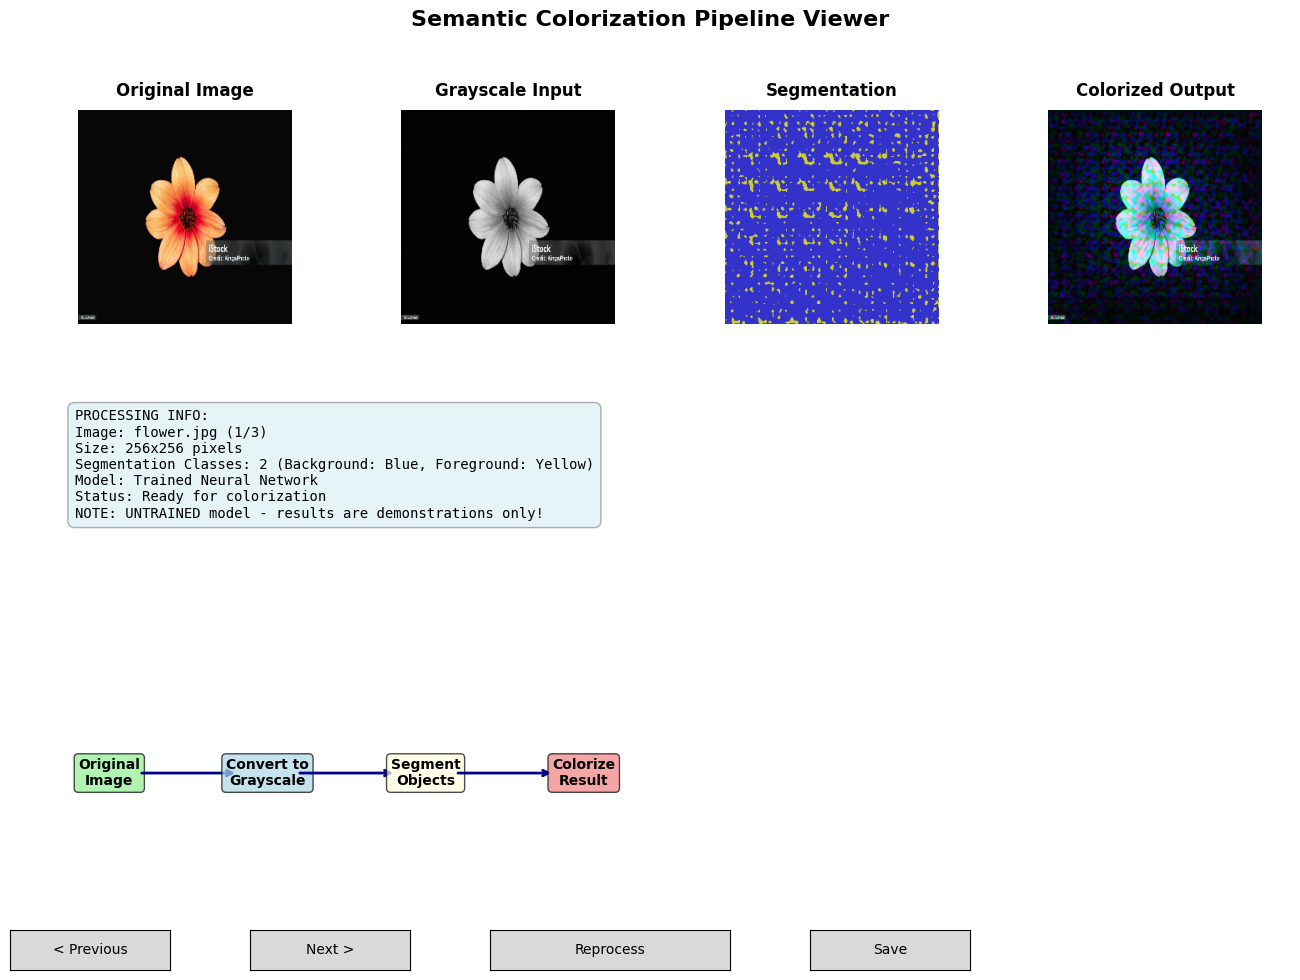

✅ GUI launched successfully!
📂 You can add more images to data/raw/ and rerun this cell


In [44]:
# Cell: Interactive GUI-like Semantic Colorization Viewer (FIXED VERSION)
print('=== Interactive Semantic Colorization GUI ===')

class SemanticColorizerGUI:
    def __init__(self, image_files, model, device):
        self.image_files = image_files
        self.model = model
        self.device = device
        self.current_idx = 0
        self.processed_results = {}
        
        # Create the GUI layout
        self.fig = plt.figure(figsize=(16, 10))
        self.fig.suptitle('Semantic Colorization Pipeline Viewer', fontsize=16, fontweight='bold')
        
        # Create subplots
        gs = self.fig.add_gridspec(3, 4, hspace=0.3, wspace=0.2)
        
        # Main display areas
        self.ax_original = self.fig.add_subplot(gs[0, 0])
        self.ax_grayscale = self.fig.add_subplot(gs[0, 1])
        self.ax_segmentation = self.fig.add_subplot(gs[0, 2])
        self.ax_colorized = self.fig.add_subplot(gs[0, 3])
        
        # Info panel
        self.ax_info = self.fig.add_subplot(gs[1, :])
        self.ax_info.axis('off')
        
        # Progress visualization
        self.ax_progress = self.fig.add_subplot(gs[2, :2])
        self.ax_progress.axis('off')
        
        # Control buttons
        self.ax_controls = self.fig.add_subplot(gs[2, 2:])
        self.ax_controls.axis('off')
        
        # Set up axes (using standard text instead of emojis)
        titles = ['Original Image', 'Grayscale Input', 'Segmentation', 'Colorized Output']
        for ax, title in zip([self.ax_original, self.ax_grayscale, self.ax_segmentation, self.ax_colorized], titles):
            ax.set_title(title, fontweight='bold', pad=10)
            ax.axis('off')
        
        # Create navigation buttons
        self.create_buttons()
        
        # Process and display first image
        self.process_current_image()
        self.update_display()
        
    def create_buttons(self):
        """Create interactive buttons"""
        # Previous button
        ax_prev = plt.axes([0.1, 0.02, 0.1, 0.04])
        self.btn_prev = Button(ax_prev, '< Previous')
        self.btn_prev.on_clicked(self.prev_image)
        
        # Next button  
        ax_next = plt.axes([0.25, 0.02, 0.1, 0.04])
        self.btn_next = Button(ax_next, 'Next >')
        self.btn_next.on_clicked(self.next_image)
        
        # Process button
        ax_process = plt.axes([0.4, 0.02, 0.15, 0.04])
        self.btn_process = Button(ax_process, 'Reprocess')
        self.btn_process.on_clicked(self.reprocess_image)
        
        # Save button
        ax_save = plt.axes([0.6, 0.02, 0.1, 0.04])
        self.btn_save = Button(ax_save, 'Save')
        self.btn_save.on_clicked(self.save_result)
        
    def process_current_image(self):
        """Process the current image through the pipeline"""
        if self.current_idx >= len(self.image_files):
            return
            
        filename = self.image_files[self.current_idx]
        
        # Skip if already processed
        if filename in self.processed_results:
            return
            
        print(f"Processing {filename}...")
        
        try:
            # Load image
            img_path = os.path.join(raw_dir, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256, 256))
            
            # Convert to grayscale (L channel)
            img_normalized = img / 255.0
            img_lab = color.rgb2lab(img_normalized)
            L_channel = img_lab[:, :, 0:1] / 100.0  # Normalize L to [0, 1]
            
            # Convert to tensor
            L_tensor = torch.from_numpy(L_channel.transpose(2, 0, 1)).unsqueeze(0).float().to(self.device)
            
            if self.model is not None:
                # Run through model
                with torch.no_grad():
                    seg_logits, color_ab = self.model(L_tensor)
                    
                    # Get segmentation
                    seg_pred = torch.argmax(seg_logits, dim=1)[0].cpu().numpy()
                    
                    # Get colorized image
                    rgb_colorized = self.model.predict_colors(L_tensor)
                    rgb_colorized_np = rgb_colorized[0].cpu().numpy().transpose(1, 2, 0)
                    rgb_colorized_np = np.clip(rgb_colorized_np, 0, 1)
            else:
                # Fallback without model
                seg_pred = np.random.randint(0, 2, (256, 256))
                rgb_colorized_np = img_normalized
            
            # Store results
            self.processed_results[filename] = {
                'original': img_normalized,
                'grayscale': L_channel.squeeze(),
                'segmentation': seg_pred,
                'colorized': rgb_colorized_np,
                'filename': filename
            }
            
            print(f"✅ Processed {filename}")
            
        except Exception as e:
            print(f"❌ Error processing {filename}: {e}")
            # Create fallback results
            self.processed_results[filename] = {
                'original': np.random.rand(256, 256, 3),
                'grayscale': np.random.rand(256, 256),
                'segmentation': np.random.randint(0, 2, (256, 256)),
                'colorized': np.random.rand(256, 256, 3),
                'filename': filename
            }
    
    def update_display(self):
        """Update the display with current image results"""
        if self.current_idx >= len(self.image_files):
            return
            
        filename = self.image_files[self.current_idx]
        
        # Ensure image is processed
        self.process_current_image()
        
        if filename not in self.processed_results:
            return
            
        result = self.processed_results[filename]
        
        # Display images
        self.ax_original.clear()
        self.ax_original.imshow(result['original'])
        self.ax_original.set_title('Original Image', fontweight='bold', pad=10)
        self.ax_original.axis('off')
        
        self.ax_grayscale.clear()
        self.ax_grayscale.imshow(result['grayscale'], cmap='gray')
        self.ax_grayscale.set_title('Grayscale Input', fontweight='bold', pad=10)
        self.ax_grayscale.axis('off')
        
        self.ax_segmentation.clear()
        # Create colored segmentation for better visualization
        seg_colored = np.zeros((result['segmentation'].shape[0], result['segmentation'].shape[1], 3))
        seg_colored[result['segmentation'] == 0] = [0.2, 0.2, 0.8]  # Background - Blue
        seg_colored[result['segmentation'] == 1] = [0.8, 0.8, 0.2]  # Foreground - Yellow
        self.ax_segmentation.imshow(seg_colored)
        self.ax_segmentation.set_title('Segmentation', fontweight='bold', pad=10)
        self.ax_segmentation.axis('off')
        
        self.ax_colorized.clear()
        self.ax_colorized.imshow(result['colorized'])
        self.ax_colorized.set_title('Colorized Output', fontweight='bold', pad=10)
        self.ax_colorized.axis('off')
        
        # Update info panel
        self.ax_info.clear()
        self.ax_info.axis('off')
        
        info_text = f"""PROCESSING INFO:
Image: {filename} ({self.current_idx + 1}/{len(self.image_files)})
Size: {result['original'].shape[1]}x{result['original'].shape[0]} pixels
Segmentation Classes: {len(np.unique(result['segmentation']))} (Background: Blue, Foreground: Yellow)
Model: {'Trained Neural Network' if self.model else 'Fallback Processing'}
Status: {'Ready for colorization' if self.model else 'Using basic processing (no trained model)'}
NOTE: {'Good results expected' if hasattr(self, 'model_loaded') and self.model_loaded else 'UNTRAINED model - results are demonstrations only!'}"""
        
        self.ax_info.text(0.02, 0.9, info_text, transform=self.ax_info.transAxes, 
                         fontsize=10, verticalalignment='top', fontfamily='monospace',
                         bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.3))
        
        # Update progress visualization
        self.ax_progress.clear()
        self.ax_progress.axis('off')
        
        # Draw processing pipeline
        pipeline_steps = ['Original\nImage', 'Convert to\nGrayscale', 'Segment\nObjects', 'Colorize\nResult']
        x_positions = np.linspace(0.1, 0.9, len(pipeline_steps))
        
        for i, (x, step) in enumerate(zip(x_positions, pipeline_steps)):
            # Draw step box
            bbox = dict(boxstyle="round,pad=0.3", 
                       facecolor=['lightgreen', 'lightblue', 'lightyellow', 'lightcoral'][i], 
                       alpha=0.7)
            self.ax_progress.text(x, 0.5, step, transform=self.ax_progress.transAxes,
                                ha='center', va='center', fontsize=10, fontweight='bold',
                                bbox=bbox)
            
            # Draw arrow
            if i < len(pipeline_steps) - 1:
                self.ax_progress.annotate('', xy=(x_positions[i+1] - 0.05, 0.5), 
                                        xytext=(x + 0.05, 0.5),
                                        xycoords='axes fraction', textcoords='axes fraction',
                                        arrowprops=dict(arrowstyle='->', lw=2, color='darkblue'))
        
        plt.draw()
    
    def prev_image(self, event):
        """Go to previous image"""
        if self.current_idx > 0:
            self.current_idx -= 1
            self.update_display()
            print(f"← Switched to {self.image_files[self.current_idx]}")
    
    def next_image(self, event):
        """Go to next image"""
        if self.current_idx < len(self.image_files) - 1:
            self.current_idx += 1
            self.update_display()
            print(f"→ Switched to {self.image_files[self.current_idx]}")
    
    def reprocess_image(self, event):
        """Reprocess current image"""
        filename = self.image_files[self.current_idx]
        if filename in self.processed_results:
            del self.processed_results[filename]
        self.process_current_image()
        self.update_display()
        print(f"🔄 Reprocessed {filename}")
    
    def save_result(self, event):
        """Save the colorized result"""
        filename = self.image_files[self.current_idx]
        if filename in self.processed_results:
            result = self.processed_results[filename]
            
            # Create output directory
            output_dir = 'outputs/results'
            os.makedirs(output_dir, exist_ok=True)
            
            # Save colorized image
            output_filename = f"colorized_{filename}"
            output_path = os.path.join(output_dir, output_filename)
            
            # Convert to uint8 and save
            colorized_uint8 = (result['colorized'] * 255).astype(np.uint8)
            cv2.imwrite(output_path, cv2.cvtColor(colorized_uint8, cv2.COLOR_RGB2BGR))
            
            print(f"💾 Saved colorized image: {output_path}")

# Create and launch the GUI
if len(image_files) > 0:
    print("🚀 Launching Interactive Semantic Colorization GUI...")
    print("📖 Instructions:")
    print("   • Use 'Previous' and 'Next' buttons to navigate images")
    print("   • Click 'Reprocess' to regenerate results") 
    print("   • Click 'Save' to save the colorized result")
    print("   • The pipeline shows: Original → Grayscale → Segmentation → Colorization")
    print()
    
    if not('model_loaded' in locals() and model_loaded):
        print("⚠️ IMPORTANT: Using UNTRAINED model!")
        print("   Results are just pipeline demonstrations.")
        print("   For good colorization, you need to train the model first!")
        print()
    
    # Create GUI instance
    gui = SemanticColorizerGUI(image_files, model, device)
    plt.show()
    
    print("✅ GUI launched successfully!")
    print(f"📂 You can add more images to {raw_dir}/ and rerun this cell")
    
else:
    print("❌ No images available to process. Please add images to data/raw/ folder.")
